# Creating a toy multi-class dataset

In [36]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [37]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("Files are already exist")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

Files are already exist


In [38]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [39]:
#Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [40]:
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features= NUM_FEATURES, 
                            centers=NUM_CLASSES, 
                            cluster_std = 1.5, 
                            random_state= RANDOM_SEED)

In [41]:
#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#Split data
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size = 0.20, random_state = 42)

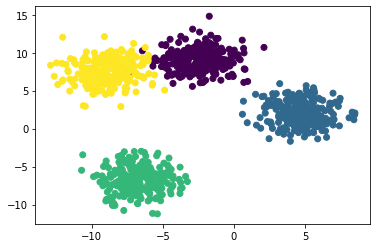

In [42]:
#Visualize data
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob)

# Building a model

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [44]:
from torch import nn

In [45]:
X_train.shape

torch.Size([800, 2])

In [46]:
torch.unique(y_train)

tensor([0, 1, 2, 3])

In [47]:
class BlobModel(nn.Module):
    
    """
    Args:
    input_features = Number of inputs
    output_features = Number of outputs(Number of output classes)
    hidden_units = Number of hidden units between layers(default 8)
    
    """
    
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features= input_features, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= output_features)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)


In [48]:
model = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
#Create a loss function and optimizer for model
loss_fn = nn.CrossEntropyLoss() #Loss function measures how wrong predictions are

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) # Optimizer updates model parameters respect to loss

# Training Loop

In [50]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100

for epoch in range(epochs):
    ###Training
    model.train()
    
    #1.Forward Pass
    y_logits = model(X_train) #Logits are raw outputs of model
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    #2.Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true= y_train, y_pred=y_pred)
    
    #3.Optimizer zero to grad
    optimizer.zero_grad()
    
    #4.Loss backward
    loss.backward()
    
    #5.Optimizer Step
    optimizer.step()
    
    ###Testing
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.2f}% Test Loss: {test_loss:.5f} Test_acc: {test_acc:.2f}%")

epoch: 0 Loss: 1.15883 Acc: 40.38% Test Loss: 1.07554 Test_acc: 48.00%
epoch: 10 Loss: 0.64476 Acc: 96.75% Test Loss: 0.66069 Test_acc: 97.50%
epoch: 20 Loss: 0.42535 Acc: 98.50% Test Loss: 0.43074 Test_acc: 100.00%
epoch: 30 Loss: 0.25294 Acc: 99.12% Test Loss: 0.24508 Test_acc: 99.50%
epoch: 40 Loss: 0.11232 Acc: 99.25% Test Loss: 0.10229 Test_acc: 99.50%
epoch: 50 Loss: 0.06627 Acc: 99.25% Test Loss: 0.05848 Test_acc: 99.50%
epoch: 60 Loss: 0.05068 Acc: 99.25% Test Loss: 0.04293 Test_acc: 99.50%
epoch: 70 Loss: 0.04300 Acc: 99.25% Test Loss: 0.03491 Test_acc: 99.50%
epoch: 80 Loss: 0.03836 Acc: 99.25% Test Loss: 0.02988 Test_acc: 99.50%
epoch: 90 Loss: 0.03525 Acc: 99.25% Test Loss: 0.02663 Test_acc: 99.50%


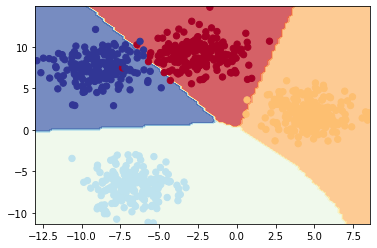

In [51]:
plot_decision_boundary(model, X_train, y_train)

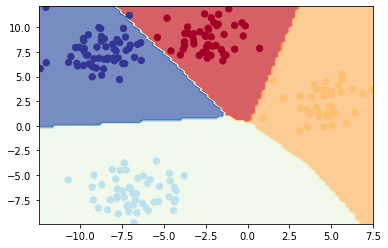

In [52]:
plot_decision_boundary(model, X_test, y_test)

In [62]:
from torchmetrics.classification import MulticlassAccuracy

torchmetric_accuracy = MulticlassAccuracy(num_classes=4).to(device)
torchmetric_accuracy(test_pred, y_test)

tensor(0.9956, device='cuda:0')